## Plotting time interval between consecutive retractions.

Update (12/3/24): This is an old file that we shall modify to plot the time between consecutive retractions. Earlier version of the file was named: validating_removing_repeated_offenders_choice.ipynb

------

In this notebook, we shall validate this choice by plotting the number of days between consecutive retractions of multiple offenders. 

In [1]:
# Importing relevant packages

import pandas as pd
import os
from config_reader import read_config
import matplotlib.pyplot as plt

In [2]:
# Reading paths
paths = read_config()
# Reading repeated offenders
PROCESSED_REPEATED_OFFENDERS = paths['PROCESSED_REPEATED_OFFENDERS']
# Path to the original RW papers 
RW_ORIGINAL_W_YEAR_LOCAL_PATH = paths['RW_ORIGINAL_W_YEAR_LOCAL_PATH']
# Path to where we will save our processed files
OUTDIR = paths['PLOTS_FOLDER_LOCAL']

In [3]:

df_offenders = pd.read_csv(PROCESSED_REPEATED_OFFENDERS)
df_papers = pd.read_csv(RW_ORIGINAL_W_YEAR_LOCAL_PATH, 
                        usecols=['Record ID','RetractionDate'])

# Removing an anomaly
df_papers = df_papers[~df_papers.RetractionDate.eq('6/24/1756 12:00:00 AM')].copy()

# Converting Retraction Date to datetime format
df_papers['RetractionDate'] = pd.to_datetime(df_papers['RetractionDate'], 
                                               format='%Y-%m-%d')


# Merging authors with retraction date of records
df_offenders_w_rdate = df_offenders.merge(df_papers, on='Record ID')

# # Grouping by author name
# df_numpapers = df_offenders_w_rdate.groupby('AuthorName')['Record ID']\
#                 .nunique().reset_index().rename(columns={'Record ID':'NumPapers'})

# Merging with number of papers
df_offenders_w_numpapers = df_offenders_w_rdate.copy()\
                                .rename(columns={'nRetracted':'NumPapers'})

# Removing authors that were not properly merged and those that are >20
df_offenders_w_numpapers = df_offenders_w_numpapers[df_offenders_w_numpapers.NumPapers.le(20) &
                                                   df_offenders_w_numpapers.NumPapers.ge(2)]

# Sorting by date
df_offenders_w_numpapers_sorted = df_offenders_w_numpapers.\
                                            sort_values(by=['AuthorName','RetractionDate'])

df_offenders_w_numpapers_sorted.head()

,Record ID,AuthorName,NumPapers,FirstRetractionYear,OffenseSameYear,RetractionDate
0,25214,a a nesterenko,3,2020,True,2020-09-25
3,25101,a a nesterenko,3,2020,True,2020-12-07
4,25083,a a nesterenko,3,2020,True,2020-12-08
12720,16742,a a zafar,2,2011,False,2011-02-22
12723,8462,a a zafar,2,2011,False,2016-03-02


In [4]:
df_offenders_w_numpapers_sorted.groupby(['AuthorName'])\
                            ['RetractionDate'].diff().dt.days.reset_index().RetractionDate.describe()

count    13049.000000
mean       421.366618
std        840.140353
min          0.000000
25%          4.000000
50%         88.000000
75%        416.000000
max      17043.000000
Name: RetractionDate, dtype: float64

In [5]:
df_offenders_w_numpapers_sorted

df_offenders_w_numpapers_sorted['Record ID 1'] = df_offenders_w_numpapers_sorted.groupby('AuthorName')['Record ID'].shift()
df_offenders_w_numpapers_sorted['Record ID 2'] = df_offenders_w_numpapers_sorted['Record ID']
df_offenders_w_numpapers_sorted['RetractionDate1'] = df_offenders_w_numpapers_sorted.groupby('AuthorName')['RetractionDate'].shift()
df_offenders_w_numpapers_sorted['RetractionDate2'] = df_offenders_w_numpapers_sorted['RetractionDate']
df_offenders_w_numpapers_sorted['Number of days'] = (df_offenders_w_numpapers_sorted['RetractionDate2'] - df_offenders_w_numpapers_sorted['RetractionDate1']).dt.days

# Drop rows where Record ID 1 is missing (last exam for each student)
new_df = df_offenders_w_numpapers_sorted.dropna(subset=['Record ID 1'])

# Reset the index of the new dataframe
new_df.reset_index(drop=True, inplace=True)

new_df = new_df.drop(columns=['AuthorName','Record ID'])

new_df.head(2)

,NumPapers,FirstRetractionYear,OffenseSameYear,RetractionDate,Record ID 1,Record ID 2,RetractionDate1,RetractionDate2,Number of days
0,3,2020,True,2020-12-07,25214.0,25101,2020-09-25,2020-12-07,73.0
1,3,2020,True,2020-12-08,25101.0,25083,2020-12-07,2020-12-08,1.0


In [6]:
new_df['Number of days'].describe()

count    13049.000000
mean       421.366618
std        840.140353
min          0.000000
25%          4.000000
50%         88.000000
75%        416.000000
max      17043.000000
Name: Number of days, dtype: float64

In [7]:
new_df['Number of days'].describe()

count    13049.000000
mean       421.366618
std        840.140353
min          0.000000
25%          4.000000
50%         88.000000
75%        416.000000
max      17043.000000
Name: Number of days, dtype: float64

In [8]:
# Define the bins and labels
bins = [0, 30, 60, 90, 180, 365, 730, 1095, 2190, 3650, float('inf')]
labels = ['0-1 month', '1-2 months', '2-3 months', '3-6 months', '6-12 months', '1-2 years',
          '2-3 years', '3-6 years', '6-10 years', '> 10 years']

# Apply the cut function to create the 'bins' column
new_df['bins'] = pd.cut(new_df['Number of days'], bins=bins, labels=labels)
new_df.loc[new_df['Number of days'] == 0, 'bins'] = '0-1 month'

In [9]:
new_df['bins'].value_counts()*100/new_df.shape[0]

bins
0-1 month      36.493218
6-12 months    12.161851
3-6 months     10.997011
1-2 years       9.625259
1-2 months      8.138555
3-6 years       7.096329
2-3 months      5.663269
2-3 years       5.234118
6-10 years      3.310599
> 10 years      1.279792
Name: count, dtype: float64

In [10]:
new_df['bins'].value_counts()

bins
0-1 month      4762
6-12 months    1587
3-6 months     1435
1-2 years      1256
1-2 months     1062
3-6 years       926
2-3 months      739
2-3 years       683
6-10 years      432
> 10 years      167
Name: count, dtype: int64

<Figure size 597.6x72 with 0 Axes>

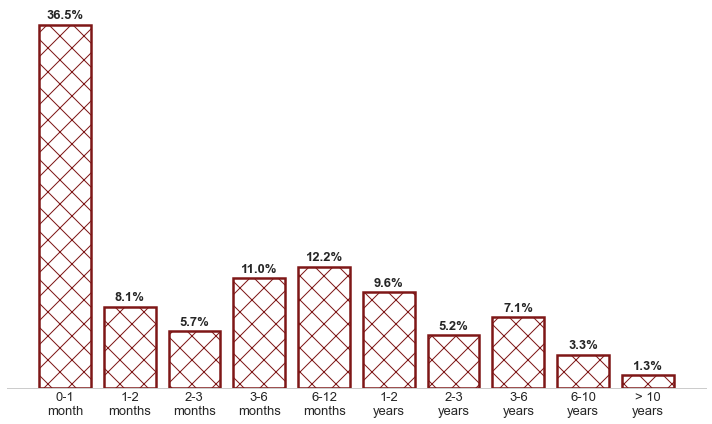

In [12]:
# Adjusting the plot style
plt.style.use('seaborn-whitegrid')


# Stretch the plot
plt.figure(figsize=(8.3, 1))


# Define the bar colors
colors = ['#7E1717'] * len(labels)

hatch_color = colors[0]
hatch_pattern = 'x'

# colors = ['#7fc97f', '#74c476', '#41ab5d', '#238b45', '#006d2c', '#00441b',
#           '#eff3ff', '#bdd7e7', '#6baed6', '#2171b5']

# Count the occurrences of each bin
bin_counts = new_df['bins'].value_counts().reindex(labels, fill_value=0)

# Calculate the percentage
percentage = bin_counts / bin_counts.sum() * 100


fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(percentage.index, percentage.values, color='none',linewidth=2.5,
              edgecolor = hatch_color, hatch=hatch_pattern)

# bars = ax.bar(bin_counts.index, bin_counts.values, color='none',linewidth=2.5,
#               edgecolor = hatch_color, hatch=hatch_pattern)

# Remove y-axis
ax.yaxis.set_visible(False)

# Increase font size of x-axis tick labels
plt.xticks(rotation=45, fontsize=13)

# Convert x tick labels to the desired format
# Convert x tick labels to the desired format
formatted_labels = {
    '0-1 month': '0-1\nmonth',
    '1-2 months': '1-2\nmonths',
    '2-3 months': '2-3\nmonths',
    '3-6 months': '3-6\nmonths',
    '6-12 months': '6-12\nmonths',
    '1-2 years': '1-2\nyears',
    '2-3 years': '2-3\nyears',
    '3-6 years': '3-6\nyears',
    '6-10 years': '6-10\nyears',
    '> 10 years': '> 10\nyears'
}

wrapped_labels = [formatted_labels.get(label, label) for label in percentage.index]
plt.xticks(range(len(percentage.index)), wrapped_labels, rotation=0)


# Add annotations on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom',
                    weight='bold',
                   fontsize=13)

# plt.xlabel('Percentage distribution of the time interval \nbetween consecutive retractions for authors with multiple retractions', 
#            fontsize=14, labelpad=15)
# plt.title('Percentage distribution of the time interval between consecutive retractions', fontsize=12)
# plt.xticks(rotation=60)
plt.grid(True)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.grid(False)
plt.tight_layout()


# Constants
OUTPUT_DIRECTORY = OUTDIR
FILENAME = "multiple_retraction_interval_percentage_distribution_new"

file_path = os.path.join(OUTPUT_DIRECTORY, f"{FILENAME}.pdf")

plt.savefig(file_path,format='pdf')

